## Support Vector Regression (SVR)

Support Vector Regression is a kernel-based model that fits a regression function 
within a specified margin of tolerance (epsilon).

Key characteristics:
- Captures complex non-linear relationships using kernels
- Sensitive to feature scale → requires scaling
- Performs well on moderate-sized atasets


## 1) Importing Dependencies and Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2) Dataset Loading and Initial Inspection

The insurance dataset contains demographic, lifestyle, and regional attributes of individuals along with their corresponding medical insurance charges.  
Initial inspection is performed to understand the structure, data types, and completeness of the dataset.

In [2]:
df=pd.read_csv('insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.region.value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [5]:
df.sex.value_counts()

sex
male      676
female    662
Name: count, dtype: int64

In [6]:
df.smoker.value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

## 3) Target Variable Distribution (Medical Insurance Charges)

Text(0.5, 1.0, 'Distribution of Medical Insurance Charges')

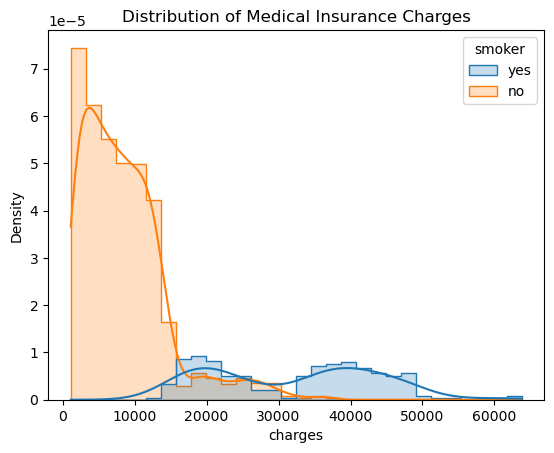

In [7]:
sns.histplot(
    data=df,
    x='charges',
    kde=True,
    hue='smoker',
    stat='density',
    element='step'
)
plt.title("Distribution of Medical Insurance Charges")

The target variable `charges` represents medical insurance costs.  
Its distribution is **right-skewed**, which violates the normality assumption of linear regression.

To stabilize variance and improve model performance, a **log transformation** of the target variable is applied.

In [8]:
df['log_charges'] = np.log(df['charges'])
df[['charges', 'log_charges']].head()

,charges,log_charges
0,16884.92400,9.734176
1,1725.55230,7.453302
2,4449.46200,8.400538
3,21984.47061,9.998092
4,3866.85520,8.260197


Text(0.5, 1.0, 'Log Charges Distribution')

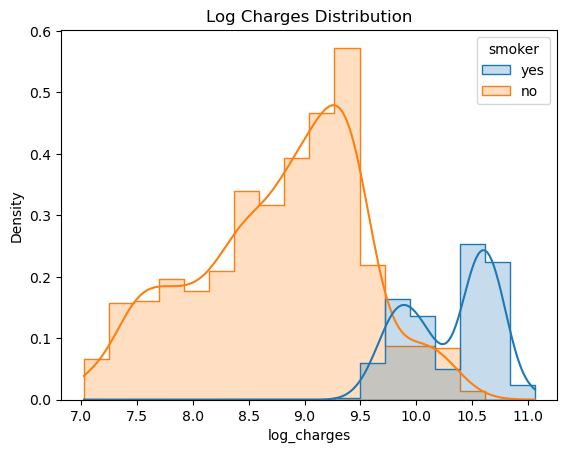

In [9]:
sns.histplot(
    data=df,
    x='log_charges',
    kde=True,
    stat='density',
    hue='smoker',
    element='step'
)
plt.title("Log Charges Distribution")

## 4) Features and Targets

In [10]:
# Features
X = df.drop(['charges', 'log_charges'], axis=1)

# Target
y = df['log_charges']

## 5) Categorical Feature Encoding

The dataset contains both numerical and categorical variables.  
Since machine learning models require numerical inputs, categorical variables must be encoded appropriately.

To avoid introducing artificial ordering and data leakage, categorical variables are encoded using **One-Hot Encoding** within a preprocessing pipeine.
.


### 5(a) Identifying Categorical & Numerical Columns

In [11]:
# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target variables from numerical list
numerical_cols.remove('charges')
numerical_cols.remove('log_charges')

In [12]:
print("Categorical Features : ",categorical_cols)
print("Numerical Features : ", numerical_cols)

Categorical Features :  ['sex', 'smoker', 'region']
Numerical Features :  ['age', 'bmi', 'children']


#### **Numerical & Categorical Features and Target**
- Numerical features : `['age', 'bmi', 'children']`
- Categorical Features : `['sex', 'smoker', 'region']`
- Target : `['log_charges']`

### 5(b) Column Transformer (Only Encoding)

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor_svr = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ]
)

## 6) Pipeline with SVR

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

svr_model = Pipeline(steps=[
    ('preprocessing', preprocessor_svr),
    ('regressor', SVR(
        kernel='rbf',
        C=10,
        epsilon=0.1,
        gamma='scale'
    ))
])

**Parameter intuition**
- `c`- penalty for errors(bias-variance tradeoff)
- `epsilon` - tolerance margin
- `gamma` - kernel influence radius

## 7) Train-Test-Split

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 8) Model Training

In [16]:
svr_model.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 9) Model Evaluation

In [17]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

train_pred = svr_model.predict(X_train)
test_pred  = svr_model.predict(X_test)

print(f"SVR Train R2 Score: {r2_score(y_train, train_pred):.4f}")
print(f"SVR Test R2 Score: {r2_score(y_test, test_pred):.4f}")
print(f"SVR Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):.4f}")

SVR Train R2 Score: 0.8530
SVR Test R2 Score: 0.8535
SVR Test RMSE: 0.3629


## 10) Hyperparameter Tuning

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__C': [1, 10, 50],
    'regressor__epsilon': [0.05, 0.1, 0.2],
    'regressor__gamma': ['scale', 0.1, 0.01]
}

In [19]:
svr_gs = GridSearchCV(
    svr_model,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

svr_gs.fit(X_train, y_train)

,estimator,"Pipeline(step..., SVR(C=10))])"
,param_grid,"{'regressor__C': [1, 10, ...], 'regressor__epsilon': [0.05, 0.1, ...], 'regressor__gamma': ['scale', 0.1, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...)]"


In [20]:
best_svr = svr_gs.best_estimator_
best_svr

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 11) Evaluation of Best SVR Model

In [21]:
best_svr_pred = best_svr.predict(X_test)

print(f"Best SVR Test R²: {r2_score(y_test, best_svr_pred):.4f}")
print(f"Best SVR Test RMSE: {np.sqrt(mean_squared_error(y_test, best_svr_pred)):.4f}")

Best SVR Test R²: 0.8619
Best SVR Test RMSE: 0.3523


## Limitations of SVR

- Computationally expensive for large datasets
- Sensitive to hyperparameters
- Less interpretable compared to linear and tree-based models

These limitations motivate the use of ensemble methods such as Random Forest and XGBoost.


## Model Comparison Summary

| Model | Target Used | Encoding | Scaling | Handles Non-Linearity | Overfitting Risk | Interpretability | Overall Performance |
|------|------------|----------|---------|-----------------------|------------------|------------------|---------------------|
| Linear Regression | log(charges) | One-Hot | ❌ Optional | ❌ No | Low | ⭐⭐⭐⭐⭐ | Baseline |
| Ridge Regression | log(charges) | One-Hot | ✅ Required | ❌ No | Lower than Linear | ⭐⭐⭐⭐ | Slightly Better |
| SVR (RBF Kernel) | log(charges) | One-Hot | ✅ Mandatory | ✅ Yes | Medium | ⭐⭐ | Moderate |
| Decision Tree | charges | One-Hot | ❌ Not Needed | ✅ Yes | ❌ High | ⭐⭐⭐ | Moderate |
| Random Forest | charges | One-Hot | ❌ Not Needed | ✅ Yes | Low | ⭐⭐⭐ | Strong |
| **XGBoost** | charges | One-Hot | ❌ Not Needed | ✅ Yes | Very Low | ⭐⭐ | ⭐⭐⭐⭐⭐ Best |


### Key Observations

- Linear and Ridge Regression provide strong baselines but are limited by linear assumptions.
- SVR captures non-linearity but is sensitive to scaling and hyperparameters.
- Decision Trees tend to overfit without regularization.
- Random Forest reduces overfitting by averaging multiple trees.
- XGBoost achieves the best performance due to boosting, regularization, and sequential error correction.
